In [11]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
exit_notes_df = pd.read_excel(r"C:\Users\jal32\Documents\NSS\Python\Projects\ddid-rasberry-pi\Data\TEIS Exit Data for NSS COPY.xlsx", sheet_name='Exit Notes')
eco_exit_df = pd.read_excel(r"C:\Users\jal32\Documents\NSS\Python\Projects\ddid-rasberry-pi\Data\TEIS Exit Data for NSS COPY.xlsx", sheet_name='ECO with Exit20-21')
eco_exit_df = eco_exit_df.head(-7)

In [13]:
teis_data_df = exit_notes_df[exit_notes_df['Exit Note'].str.contains('reopened', case=False, na=False)].reset_index(drop=True)
reopened_df = teis_data_df.drop(columns=['POE', 'Notification Date', 'Initial Eligibility Date', 'Latest IFSP Date'])

In [14]:
dates_df = reopened_df['Exit Note'].str.findall('(\\d{2}/\\d{2}/\\d{4})')
dates_df = dates_df.to_frame()

dates_df['total_dates'] = dates_df['Exit Note'].apply(lambda x: len(str(x).split(' ')))

dates_df.total_dates.describe()

reopened_df['reopened_dates'] = reopened_df['Exit Note'].str.findall('Reopened: \\d{2}/\\d{2}/\\d{4}')
reopened_df['exit_dates'] = reopened_df['Exit Note'].str.findall('Exit Date: \\d{2}/\\d{2}/\\d{4}')

reopen_date_df = reopened_df.reopened_dates.to_frame().astype(str)
exit_date_df = reopened_df.exit_dates.to_frame().astype(str)

reopen_date_df = reopen_date_df.reopened_dates.str.split(',', expand=True)
reopen_date_df.columns = ['reopen1', 'reopen2', 'reopen3', 'reopen4', 'reopen5', 'reopen6']
exit_date_df = exit_date_df.exit_dates.str.split(',', expand=True)
exit_date_df.columns = ['exit1', 'exit2', 'exit3', 'exit4', 'exit5', 'exit6']

cols_r = ['reopen1', 'reopen2', 'reopen3', 'reopen4', 'reopen5', 'reopen6']
cols_e = ['exit1', 'exit2', 'exit3', 'exit4', 'exit5', 'exit6']

reopen_date_df[cols_r] = reopen_date_df[cols_r].replace({'\[':'', '\]':'', '\'':'', 'Reopened:':''}, regex=True)
exit_date_df[cols_e] = exit_date_df[cols_e].replace({'\[':'', '\]':'', '\'':'', 'Exit Date:':''}, regex=True)

In [15]:
reopen_exit_date_df = reopen_date_df.join(exit_date_df)

cols_r_e =  ['reopen1', 'reopen2', 'reopen3', 'reopen4', 'reopen5', 'reopen6',
             'exit1', 'exit2', 'exit3', 'exit4', 'exit5', 'exit6']
             
reopen_exit_date_df = reopen_exit_date_df.astype('datetime64')
reopen_exit_date_df = reopen_exit_date_df.reindex(columns=['exit1', 'reopen1', 'exit2', 'reopen2', 'exit3', 'reopen3', 'exit4', 'reopen4', 'exit5', 'reopen5', 'exit6', 'reopen6'])

ifsp_date = reopened_df[['Child ID', 'DOB', 'Initial IFSP Date', 'Exit Date', 'Days from I-IFSP to Exit']]
ifsp_date[['Initial IFSP Date', 'Exit Date']].astype('datetime64')
ifsp_date['age3_date'] = ifsp_date['DOB'] + pd.offsets.DateOffset(years=3)
reopen_exit_date_df = ifsp_date.join(reopen_exit_date_df)

###IF REOPEN DATE IS AFTER EXIT DATE, CHANGE EXIT DATE TO CURRENT DAY
reopen_exit_date_df.loc[reopen_exit_date_df.reopen1 > reopen_exit_date_df['Exit Date'], ['Exit Date']] = pd.to_datetime('today').normalize()

###IF EXIT DATE IS AFTER THEIR 3RD BIRTHDAY, CHANGE EXIT DATE TO AGE3_DATE
reopen_exit_date_df['Exit Date'] = np.where(reopen_exit_date_df['Exit Date'] > reopen_exit_date_df.age3_date, reopen_exit_date_df.age3_date, reopen_exit_date_df['Exit Date'])

###RECALCULATE DAYS FROM I-IFSP TO EXIT
reopen_exit_date_df['Days from I-IFSP to Exit'] = reopen_exit_date_df['Exit Date'] - reopen_exit_date_df['Initial IFSP Date']

###SET REOPEN TO NULL IF THE DATE LISTED IS EQUAL TO OR AFTER AGE3_DATE
reopen_exit_date_df.loc[reopen_exit_date_df.reopen1 > reopen_exit_date_df.age3_date, ['reopen1']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen1 == reopen_exit_date_df.age3_date, ['reopen1']] = 'NaT'

###SET REOPEN TO NULL IF THE DATE LISTED IS EQUAL TO EXIT DATE
reopen_exit_date_df.loc[reopen_exit_date_df.reopen1 == reopen_exit_date_df['Exit Date'], ['reopen1']] = 'NaT'

###SET 'EXIT'/'REOPEN TO NULL IF THE DATE LISTED IS BEFORE THE INITIAL IFSP DATE
reopen_exit_date_df.loc[reopen_exit_date_df.exit1 < reopen_exit_date_df['Initial IFSP Date'], ['exit1']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.exit2 < reopen_exit_date_df['Initial IFSP Date'], ['exit2']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.exit3 < reopen_exit_date_df['Initial IFSP Date'], ['exit3']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.exit4 < reopen_exit_date_df['Initial IFSP Date'], ['exit4']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.exit5 < reopen_exit_date_df['Initial IFSP Date'], ['exit5']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.exit6 < reopen_exit_date_df['Initial IFSP Date'], ['exit6']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen1 < reopen_exit_date_df['Initial IFSP Date'], ['reopen1']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen2 < reopen_exit_date_df['Initial IFSP Date'], ['reopen2']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen3 < reopen_exit_date_df['Initial IFSP Date'], ['reopen3']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen4 < reopen_exit_date_df['Initial IFSP Date'], ['reopen4']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen5 < reopen_exit_date_df['Initial IFSP Date'], ['reopen5']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen6 < reopen_exit_date_df['Initial IFSP Date'], ['reopen6']] = 'NaT'

#
reopen_exit_date_df = reopen_exit_date_df[reopen_exit_date_df.exit1.notnull()].reset_index(drop=True)

reopen_exit_date_df.exit1 = np.where(reopen_exit_date_df.exit1 == reopen_exit_date_df['Exit Date'], reopen_exit_date_df.exit2, reopen_exit_date_df.exit1)

reopen_exit_date_df['r1-e1'] = reopen_exit_date_df.reopen1 - reopen_exit_date_df.exit1
reopen_exit_date_df['r2-e2'] = reopen_exit_date_df.reopen2 - reopen_exit_date_df.exit2
reopen_exit_date_df['r3-e3'] = reopen_exit_date_df.reopen3 - reopen_exit_date_df.exit3
reopen_exit_date_df['r4-e4'] = reopen_exit_date_df.reopen4 - reopen_exit_date_df.exit4
reopen_exit_date_df['r5-e5'] = reopen_exit_date_df.reopen5 - reopen_exit_date_df.exit5
reopen_exit_date_df['r6-e6'] = reopen_exit_date_df.reopen6 - reopen_exit_date_df.exit6
reopen_exit_date_df.dtypes

reopen_exit_date_df['r1-e1'] = reopen_exit_date_df['r1-e1'].fillna(pd.Timedelta(seconds=0))
reopen_exit_date_df['r2-e2'] = reopen_exit_date_df['r2-e2'].fillna(pd.Timedelta(seconds=0))
reopen_exit_date_df['r3-e3'] = reopen_exit_date_df['r3-e3'].fillna(pd.Timedelta(seconds=0))
reopen_exit_date_df['r4-e4'] = reopen_exit_date_df['r4-e4'].fillna(pd.Timedelta(seconds=0))
reopen_exit_date_df['r5-e5'] = reopen_exit_date_df['r5-e5'].fillna(pd.Timedelta(seconds=0))
reopen_exit_date_df['r6-e6'] = reopen_exit_date_df['r6-e6'].fillna(pd.Timedelta(seconds=0))

reopen_exit_date_df['day_diff'] = reopen_exit_date_df['r1-e1'] + reopen_exit_date_df['r2-e2'] + reopen_exit_date_df['r3-e3'] + reopen_exit_date_df['r4-e4'] + reopen_exit_date_df['r5-e5'] + reopen_exit_date_df['r6-e6']
reopen_exit_date_df.day_diff = reopen_exit_date_df.day_diff.astype('timedelta64[D]').astype(int)
reopen_exit_date_df['actual_service_time'] = reopen_exit_date_df['Days from I-IFSP to Exit'].astype('timedelta64[D]').astype(int) - reopen_exit_date_df.day_diff

<ipython-input-15-701111cefbf7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ifsp_date['age3_date'] = ifsp_date['DOB'] + pd.offsets.DateOffset(years=3)


In [18]:
service_time_df = reopen_exit_date_df[['Child ID', 'actual_service_time']]

initial_final_merge = exit_notes_df.merge(service_time_df, how='outer')
initial_final_merge.actual_service_time = initial_final_merge.actual_service_time.fillna(initial_final_merge['Days from I-IFSP to Exit']).astype(int)

initial_final_merge['change_bool'] = np.where(initial_final_merge.actual_service_time == initial_final_merge['Days from I-IFSP to Exit'], 0, 1).astype(bool)
initial_final_merge['service_change'] = (initial_final_merge['Days from I-IFSP to Exit'] - initial_final_merge.actual_service_time).abs()

service_time_stats_df = initial_final_merge['service_change']
service_time_stats_df = service_time_stats_df.to_frame()
service_time_stats_df = service_time_stats_df[service_time_stats_df.service_change != 0].reset_index(drop=True)
service_time_stats_df.describe()

calc_merge = eco_exit_df.join(initial_final_merge.set_index('Child ID'), on='CHILD_ID', lsuffix='_left', rsuffix='_right')
calc_merge.actual_service_time_right = calc_merge.actual_service_time_right.fillna(calc_merge['Days btw Initial and Exit']).astype(int)
calc_merge['Days from I-IFSP to Exit'] = calc_merge['Days from I-IFSP to Exit'].fillna(calc_merge['Days btw Initial and Exit']).astype(int)
calc_merge.change_bool = np.where(calc_merge.actual_service_time_right == calc_merge['Days btw Initial and Exit'], 0, 1).astype(bool)
calc_merge.service_change = (calc_merge['Days from I-IFSP to Exit'] - calc_merge.actual_service_time_right).abs()

initial_final_merge

,POE,Child ID,DOB,Notification Date,Initial Eligibility Date,Initial IFSP Date,Latest IFSP Date,Exit Reason,Exit Date,Days from I-IFSP to Exit,Exit Note,actual_service_time,change_bool,service_change
0,UC,471738,2019-02-28,2019-10-17,2019-10-29,2019-10-31,2020-05-12,618 - Parent withdraw,2020-09-21,326,* No Exit ECO available due to COVID-19,326,False,0
1,FT,449030,2018-07-22,2018-11-07,2018-12-03,2018-12-18,2021-03-04,618 - Moved out of state,2021-03-06,809,"***family moving out of state March 2021, and ...",809,False,0
2,FT,463311,2017-07-09,2019-05-24,2019-06-19,2019-07-02,2020-06-22,618 - Part B eligibility not determined,2020-07-08,372,**Completed the transition planning conference...,372,False,0
3,FT,463313,2017-07-09,2019-05-24,2019-06-19,2019-07-02,2020-06-22,618 - Part B eligibility not determined,2020-07-08,372,**Completed the transition planning conference...,372,False,0
4,FT,469194,2017-08-31,2019-09-04,2019-10-02,2019-10-11,2020-05-26,618 - Part B eligibility not determined,2020-08-30,324,**Due to the impact of the COVID-19 pandemic a...,324,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5577,MD,491609,2018-12-22,2020-10-20,2020-10-30,2020-11-09,2021-03-05,618 - Attempts to contact unsuccessful,2021-05-17,189,NaN,189,False,0
5578,GN,491743,2018-06-05,2020-10-22,2020-11-05,2020-11-09,2021-05-04,618 - Part B eligibility not determined,2021-06-04,207,NaN,207,False,0
5579,ET,491879,2019-04-24,2020-10-26,2020-11-02,2020-11-04,2021-04-15,618 - Parent withdraw,2021-05-06,183,NaN,183,False,0
5580,SC,492267,2018-06-01,2020-10-30,2020-11-17,2020-11-24,2021-04-15,618 - Part B eligibility not determined,2021-05-31,188,NaN,188,False,0


In [21]:
initial_final_merge['Days Affected'] = initial_final_merge['Days from I-IFSP to Exit'] - initial_final_merge['actual_service_time']
Total = initial_final_merge['service_change'].sum()
Total

136658

In [37]:
initial_final_merge['greater_182'] = initial_final_merge['actual_service_time'] >= 182
initial_final_merge['lesser_182'] = initial_final_merge['actual_service_time'] < 182


In [40]:
initial_final_merge['Exit Note'].duplicated().value_counts()

True     3367
False    2215
Name: Exit Note, dtype: int64

Text(0.5, 1.0, 'Child Age at Exit v Actual Service Time')

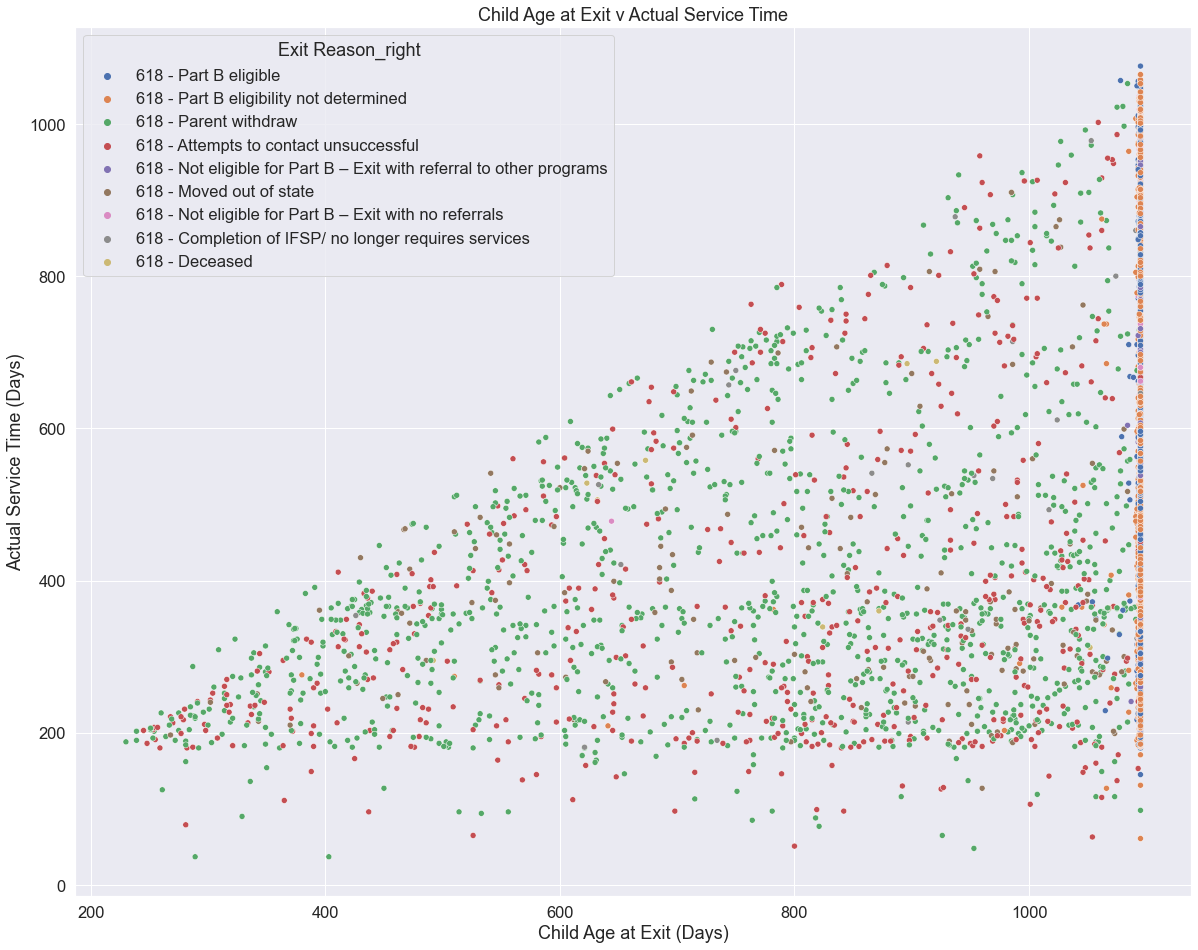

In [17]:
calc_merge['child_age_at_exit'] = calc_merge['Exit Date_left'] - calc_merge['DOB_left']
calc_merge.child_age_at_exit = calc_merge.child_age_at_exit.astype(str).str.replace(' days', '').astype(int)
calc_merge.actual_service_time_right = np.where(calc_merge.actual_service_time_right > calc_merge.child_age_at_exit, calc_merge.child_age_at_exit, calc_merge.actual_service_time_right)

plt.figure(figsize = (20,16))
sns.set_style('dark')
sns.set(font_scale=1.5)

#plt.ylim(0, 182)

calc_merge_scatter = sns.scatterplot(data = calc_merge,
                                     x = 'child_age_at_exit',
                                     y = 'actual_service_time_right',
                                     hue = 'Exit Reason_right')

calc_merge_scatter.set_xlabel('Child Age at Exit (Days)')
calc_merge_scatter.set_ylabel('Actual Service Time (Days)')
calc_merge_scatter.set_title('Child Age at Exit v Actual Service Time')